<a href="https://colab.research.google.com/github/andrefsc/SDC_M04/blob/main/M06_TareaIndividual_Parte1_AndreCastanho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Master en Inteligência Artificial en el Deporte, Edición 8**

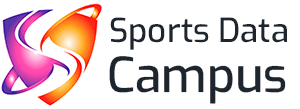

__Tarea Individual Módulo 6 - Parte 1__
````
Análisis de sentimiento con BERT : Reviews de Películas

La primera parte de esta tarea consiste en utilizar el modelo BERT para realizar un análisis de sentimiento de reviews de películas.

Utilizaremos el notebook Tarea_Modulo_6_Parte_1.ipynb cómo plantilla, donde se necesitan completar varias celdas del notebook con
el código necesario para realizar las tareas que se piden (Instrucciones al principio del notebook).
Además, se deben contestar un par de preguntas sobre el desarrollo al final del notebook.

---

André Silveira Castanho
April, 2024

`````

**Explicación del Código**

````
Este código permite acceder a los archivos almacenados en Google Drive desde un cuaderno de Colab, montando el Google Drive
como un sistema de archivos en la ruta especificada (/content/drive).

````

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


El ambiente virtual de Google Colab ya incluye muchas de las bibliotecas comúnmente usadas en tareas de inteligencia artificial.
No obstante, es necesario añadir la biblioteca **transformers** de Huggingface y **tqdm**, que facilita la visualización de barras de progreso en bucles for.

In [2]:
!pip install transformers
!pip install tqdm

# 0. Imports

En la sección **Imports** agrupamos todas las librerías y clases que debemos importar en esta tarea.

In [3]:
# import basic libraries for data science
import pandas as pd # para manipulación y análisis de datos
import numpy as np # para operaciones matemáticas de alto nivel
import matplotlib.pyplot as plt # para la visualización de datos

# import torch and transformers
import torch # el framework principal para operaciones con tensores y redes neuronales
from torch import cuda # de PyTorch, para operaciones en GPUs
from torch.utils.data import Dataset, DataLoader # para manejar y cargar datos en formato adecuado para entrenar modelos con PyTorch
from transformers import AutoModelForSequenceClassification, AutoTokenizer # de la biblioteca transformers, para cargar modelos preentrenados
                                                                           # y tokenizadores que se ajustan automáticamente al modelo

# import different metrics for evaluation
# Para evaluar el rendimiento de modelos de clasificación
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, accuracy_score, f1_score

# import tqdm to track progress
# para mostrar barras de progreso en bucles, facilitando el seguimiento de largas ejecuciones
from tqdm import tqdm
from tqdm.notebook import tqdm

# import some python modules required for some of the utility functions
import itertools # ofrece construcciones eficientes de bucles
import re # para operaciones de expresiones regulares
import os # para interactuar con el sistema operativo, como manejo de archivos y directorios

# 1. Functions Utils

En la sección **Functions Utils** se encuentran varias funciones de utilidad con sus docstrings que se utilizarán a largo de la implementación para preprocesar y limpiar datos y también evaluar los resultados.

**1.1. Text Processing and Cleaning Functions**

**Función: encode_sentiment**

````
Función que codifica etiquetas de sentimiento textual a formato numérico.
Recibe un argumento sentiment, que es una cadena de texto que puede ser "positive" o cualquier otro valor que se considerará negativo.
Retorna 1 si el sentimiento es "positive" y 0 en cualquier otro caso.
Esto es útil para convertir datos categóricos de texto en formatos numéricos que pueden ser procesados por algoritmos de aprendizaje automático.

````

In [4]:
def encode_sentiment(sentiment):
  """
  Label encode sentiment.

  Parameters
  ----------
  sentiment: str, sentiment {"positive", "sentiment"}

  Returns
  -------
  int, 1's for positive and 0's for negative

  """
  if sentiment == "positive":
    return 1
  else:
    return 0

**Función: is_ascii**

````
Función que determina si un carácter es de tipo ASCII.
Recibe como parámetro w, que es un carácter en forma de cadena de texto.
Retorna True si el carácter puede ser codificado en ASCII, y False si no puede, lo cual indicaría que el carácter incluye símbolos o letras especiales que no están incluidos en la tabla ASCII estándar.
Este tipo de función es útil para filtrar o validar textos que deben cumplir con ciertos estándares de codificación.
````

In [5]:
def is_ascii(w):
  """
  Check if character is ascii type.

  Parameters
  ----------
  w: str, character

  Returns
  -------
  bool, True if character is ascii. False otherwise.
  """
  try:
    w.encode("ascii")
    return True
  except UnicodeEncodeError:
    return False

**Función: text_cleaning**
````
Función que utiliza para limpiar un texto de símbolos, puntuación y otros elementos no deseados, facilitando su procesamiento posterior en tareas de análisis de texto. La función text_cleaning realiza las siguientes operaciones sobre el texto que recibe como parámetro text:

1. Eliminar formatos de cadena como saltos de línea (\n) y tabulaciones (\t),reemplazándolos por un punto y espacio para mantener la separación de las sentencias.
2. Excluir palabras con caracteres no-ASCII, es decir, filtrar palabras que contengan caracteres especiales o acentuados que no se encuentren en la codificación ASCII estándar.
3. Eliminar direcciones de correo electrónico que comienzan con "@", y URLs completas que comiencen con "http" o "www".
4. Remover puntuación, manteniendo únicamente puntos y comas para no alterar el fin de las sentencias ni los elementos decimales, y convertir todo el texto a minúsculas para homogeneizar la capitalización.

El resultado es un texto limpio (cleaned_text) que solamente contiene palabras en letras minúsculas y caracteres ASCII, con puntos y comas como única puntuación, lo cual simplifica análisis posteriores como la tokenización o el modelado de lenguaje natural.
````


In [6]:
def text_cleaning(text):
  """
  Clean text from symbols, punctuation, etc.

  Parameters
  ----------
  text: string, text data

  Returns
  -------
  cleaned_text: string, cleaned text data
  """
  # remove string formatting '\n' or '\t'
  tmp_text = re.sub(r'\n+', '. ', text)
  tmp_text = re.sub(r'\t+', '. ', text)
  # remove words with non-ascii characters
  tmp_text = " ".join([word for word in tmp_text.split() if is_ascii(word)])
  # remove email address
  tmp_text = " ".join([word for word in tmp_text.split() if not word.startswith("@")])
  # remove urls
  tmp_text = re.sub(r'http\S+', '', tmp_text, flags=re.MULTILINE)
  tmp_text = re.sub(r'www\S+', '', tmp_text, flags=re.MULTILINE)
  # remove punctuation but . (to split sentences)
  cleaned_text = re.sub('[^A-Za-z.,]+', ' ', tmp_text)
  # lowercase
  cleaned_text = cleaned_text.lower()

  return cleaned_text

**1.2. Evaluation Functions**

**Función: plot_confusion_matrix**

````
Función que permite visualizar la matriz de confusión de un modelo de clasificación, que ayuda a evaluar su precisión.
Puede normalizar la matriz para comparar proporciones y utiliza un mapa de colores para representar los valores.
Los elementos de la matriz se anotan con valores numéricos, ajustando el color del texto para mejorar la legibilidad según el fondo.

Nota:
interpolation='nearest': Este argumento especifica el método de interpolación para renderizar la imagen.
La opción 'nearest' utiliza el valor del píxel más cercano para colorear cada píxel visualizado, lo que ayuda a mantener
la fidelidad de los valores originales sin suavizarlos. Esto es ideal para visualizar claramente cada valor de la matriz sin efectos de interpolación entre píxeles.

````

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

# 2. Settings

En la sección **Settings** definimos variables y objetos que utilizaremos en el desarrollo y queremos tener agrupados en el mismo lugar.

**Definición de Variables Clave:**

````
MAX_LEN = 512: Establece el número máximo de tokens a 512 para los textos que se procesarán, lo cual es importante para definir la longitud de entrada que el modelo puede manejar.
BATCH_SIZE = 64: Define el tamaño del lote para el entrenamiento del modelo, lo que afecta directamente la memoria que se consumirá y la velocidad de entrenamiento.
SEED = 42: Fija una semilla para el generador de números aleatorios para garantizar resultados reproducibles.

````

In [8]:
# Defining some key variables that will be used later on
MAX_LEN = 512 # max number of tokens
BATCH_SIZE = 64
SEED = 42 # for reprodudible results

**Inicialización del Tokenizador:**

````
Carga un tokenizador preentrenado del modelo 'distilbert-base-uncased-finetuned-sst-2-english', que es útil para convertir texto
en tokens que el modelo de Transformers puede procesar`
````

In [9]:
# Initialiaze model tokenizer
TOKENIZER = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

**Configuración del Dispositivo:**

````
Determina si se utilizará una GPU (con CUDA) o una CPU para el entrenamiento, dependiendo de la disponibilidad.
Esto es crucial para la eficiencia en el entrenamiento, ya que las GPUs permiten una computación más rápida.

````

In [10]:
# Setting up the device for GPU usage if available
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# 3. Data

En la sección **Data** necesitamos cargar los datos en un dataframe de pandas, codificar el sentimiento y limpiar el texto.

Podeis hacer uso de las funciones de utilidad **encode_sentiment()** y **text_cleaning()**.

**Explicación del Código**

````
Carga un conjunto de datos desde un archivo CSV llamado '01_dataset.csv' ubicado en el directorio 'sample_data'.

Luego aplica una función de codificación a la columna 'sentiment' de los datos cargados. La función encode_sentiment se utiliza
para convertir los valores textuales de la columna 'sentiment' en valores numéricos, específicamente transformando los
sentimientos "positive" en 1 y cualquier otro sentimiento en 0. Esta codificación es útil para procesos de análisis de
datos y modelos de aprendizaje automático que requieren entradas numéricas.

Cargar Datos: Se leen los datos del archivo CSV utilizando pd.read_csv() de la biblioteca Pandas y se almacenan en el DataFrame raw_data.

Codificar Sentimientos: Se modifica la columna 'sentiment' del DataFrame aplicando la función encode_sentiment a cada elemento.
Esto convierte los sentimientos textuales en valores binarios numéricos, facilitando su uso en análisis estadísticos y modelos predictivos.

````

In [11]:
### 1. Escribir código para cargar los datos y codificar la columna sentiment.###

# Carregar os dados do arquivo CSV no diretório de GoogleDrive
file_path = '/content/drive/MyDrive/Colab_notebooks/Files/01_dataset.csv'
raw_data = pd.read_csv(file_path)

# Aplicar a função de codificação na coluna 'sentiment'
raw_data['sentiment'] = raw_data['sentiment'].apply(encode_sentiment)

**Explicación del Código**

````
El método raw_data.info(), se emplea para obtener un resumen conciso del DataFrame raw_data.
Este método es extremadamente útil para obtener información fundamental sobre la estructura y las características del DataFrame,
especialmente antes de proceder con análisis más detallados o la limpieza de datos.

````

In [12]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


**Explicación del Código**

````
El método raw_data.head(10), se emplea para visualizar las primeras 10 filas del DataFrame raw_data.
Se pretende obtener una rápida visión general de los datos, especialmente para verificar la estructura inicial del DataFrame,
los tipos de datos y las primeras entradas.

````

In [13]:
raw_data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


**Explicación del Código**

````
Para contar cuántos sentimientos son representados por 0 (negativos) y cuántos por 1 (positivos) en un DataFrame de pandas,
se utiliza el método value_counts() aplicado a la columna correspondiente, que en tu caso es 'sentiment'.

````

In [14]:
df = pd.DataFrame(raw_data)

# Aplicando value_counts() na coluna 'sentiment'
sentiment_counts = df['sentiment'].value_counts()

# Imprimindo o resultado
print(sentiment_counts)

sentiment
1    25000
0    25000
Name: count, dtype: int64


**Explicación del Código**

````
Copia un DataFrame, limpia la columna 'review' usando la función text_cleaning() para eliminar caracteres indeseados
y normalizar el texto, y muestra las primeras 10 filas del resultado para verificar la limpieza aplicada.

````

In [15]:
### 2. Escribir código para limpiar el texto utilizando la función text_cleaning() ###
### Sustituir None por el código necesario ###

# Crear una copia del DataFrame original para aplicar la limpieza
cleaned_data = raw_data.copy()

# Aplicar la función 'text_cleaning' en la columna 'review'
cleaned_data["review"] = cleaned_data["review"].apply(text_cleaning)

cleaned_data.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. br br the filmi...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1
5,"probably my all time favorite movie, a story o...",1
6,i sure would like to see a resurrection of a u...,1
7,"this show was an amazing, fresh innovative ide...",0
8,encouraged by the positive comments about this...,0
9,if you like original gut wrenching laughter yo...,1


**Explicación del Código**

````
Genera y muestra un resumen estadístico de la columna 'sentiment' del DataFrame cleaned_data, incluyendo conteo, media,
desviación estándar, mínimos, máximos y percentiles. Esta información ayuda a entender la distribución de los datos de polaridad.
````

In [16]:
# Descripción estadística de la polaridad (sentiment)
print(cleaned_data['sentiment'].describe())

count    50000.000000
mean         0.500000
std          0.500005
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: sentiment, dtype: float64


**Explicación del Código**

````
Se genera un gráfico de barras que representa la distribución de frecuencias de los diferentes sentimientos
en la columna 'sentiment' del DataFrame cleaned_data.
````

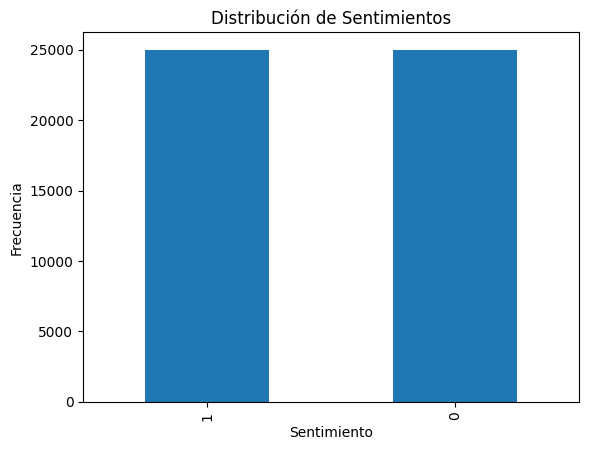

In [17]:
# Distribución de sentimientos
cleaned_data['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()


**Explicación del Código**

````
Se utiliza las librerías matplotlib.pyplot y WordCloud para generar y visualizar una nube de palabras a partir de las reseñas contenidas
en la columna review del DataFrame cleaned_data. Primero, concatena todos los textos de esta columna en una sola cadena.
Luego, crea una nube de palabras que visualiza la frecuencia de cada término.  
La visualización resultante muestra claramente cuáles términos son más comunes en las reseñas, ayudando a identificar rápidamente
los temas más destacados discutidos por los usuarios.
````

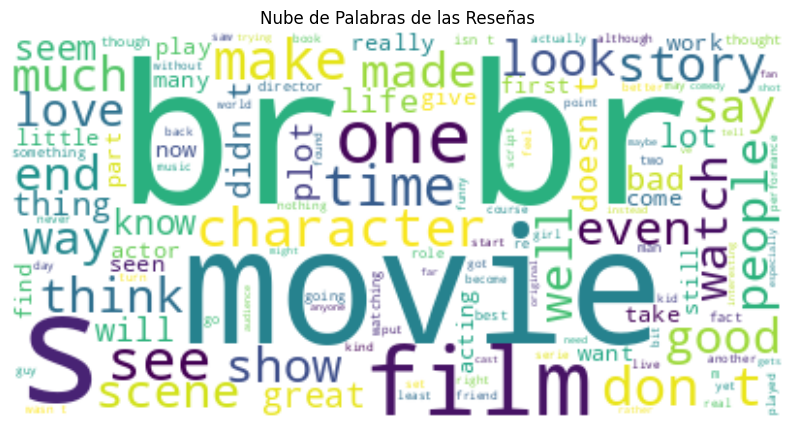

In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Asumiendo que 'cleaned_data' es tu DataFrame y ya está cargado
# y que la columna 'review' ya está limpia para el procesamiento de texto.

# Generación de la nube de palabras
text = ' '.join(review for review in cleaned_data['review'])  # Utilizando la columna correcta
word_cloud = WordCloud(colormap='viridis', max_font_size=100, background_color='white').generate(text)

# Visualización de la nube de palabras
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de las Reseñas')
plt.show()

**Explicación del Código**

````
Aqui se utiliza la biblioteca TextBlob para analizar el sentimiento de las reseñas en el DataFrame cleaned_data.
Define y aplica una función, detailed_sentiment, que clasifica cada reseña en categorías de sentimiento desde "Muy positivo" a "Muy negativo" basado en la polaridad calculada.
Esta función se aplica a las primeras 5000 reseñas y los resultados se visualizan en un gráfico de barras, mostrando la distribución de estos sentimientos detallados.
Esto permite una evaluación rápida y visual del tono general de las reseñas en el conjunto de datos.

````

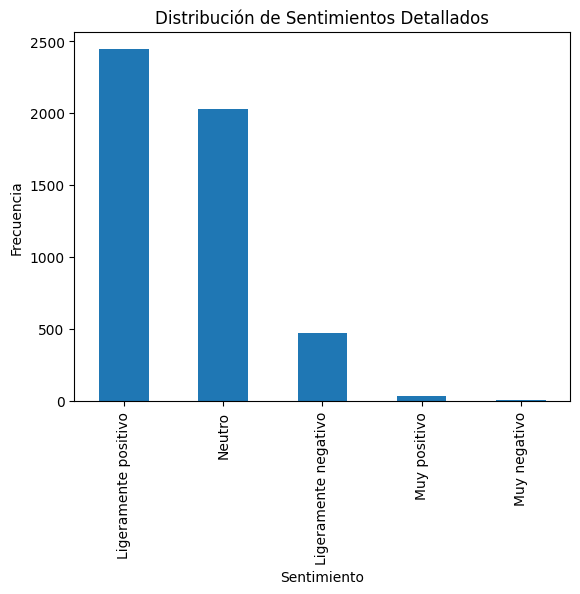

In [19]:
from textblob import TextBlob

def detailed_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.5:
        return 'Muy positivo'
    elif polarity > 0.1:
        return 'Ligeramente positivo'
    elif polarity > -0.1:
        return 'Neutro'
    elif polarity > -0.5:
        return 'Ligeramente negativo'
    else:
        return 'Muy negativo'

cleaned_data['detailed_sentiment'] = cleaned_data['review'][:5000].apply(detailed_sentiment)
cleaned_data['detailed_sentiment'].value_counts().plot(kind='bar')
plt.title('Distribución de Sentimientos Detallados')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

**Explicación del Código**

````
Se utiliza técnicas de procesamiento de texto para analizar reseñas mediante CountVectorizer y Latent Dirichlet Allocation (LDA) de la librería sklearn.
Primero, convierte las reseñas a una matriz numérica de términos-frecuencia, ignorando las palabras más comunes y ajustando la matriz por frecuencias de aparición.
Luego, aplica LDA para identificar cinco tópicos principales en los textos, y visualiza las palabras clave de cada tópico, facilitando la comprensión de los temas predominantes en las reseñas.
El objetivo es descubrir y presentar los temas recurrentes para su análisis y toma de decisiones basadas en datos.
````

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorización de texto
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf = tf_vectorizer.fit_transform(cleaned_data['review'])

# LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(tf)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Tema %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, tf_vectorizer.get_feature_names_out(), 10)

Tema 0:
movie film like just good really movies don time bad
Tema 1:
movie like great good love funny just comedy old little
Tema 2:
film movie just like horror bad plot br good really
Tema 3:
br movie like just good really don time film bad
Tema 4:
film br story life films time man character best great


**Explicación del Código**

````
Aqui se añade dos nuevas columnas al DataFrame cleaned_data: sentence_length y word_length, que contienen, respectivamente, la longitud de las sentencias en palabras y la longitud promedio de las palabras de cada reseña.
Para visualizar la distribución de estas métricas, se generan dos histogramas con curvas de estimación de densidad de kernel (KDE), uno para la longitud de las sentencias y otro para la longitud de las palabras, utilizando la función sns.histplot de Seaborn.
El objetivo principal de este código es explorar la estructura textual de las reseñas, proporcionando una visión general sobre la complejidad y diversidad del texto analizado, lo cual puede ser útil para tareas como la optimización de modelos de procesamiento de lenguaje natural o para mejoras en sistemas de análisis de texto.
````

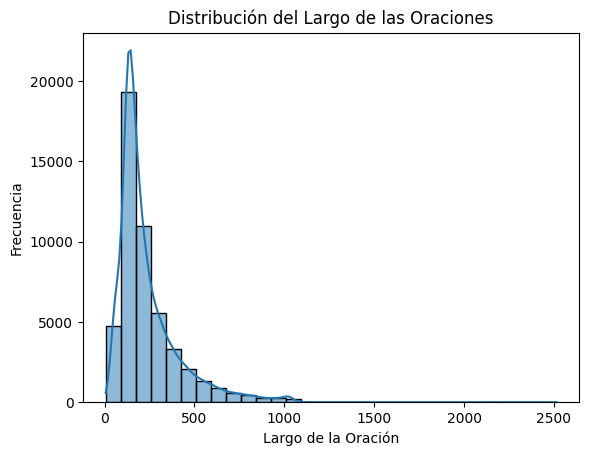

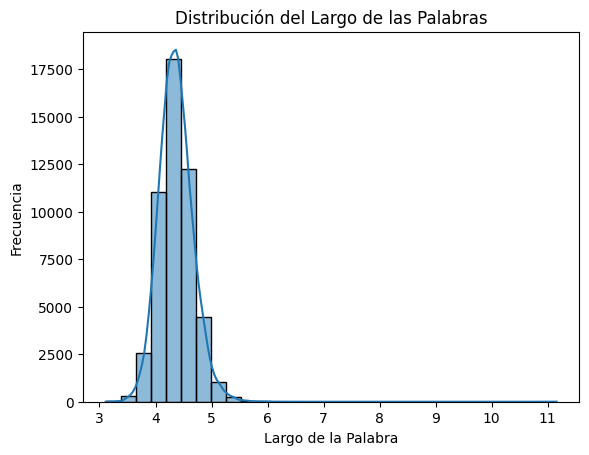

In [21]:
import seaborn as sns

cleaned_data['sentence_length'] = cleaned_data['review'].apply(lambda x: len(x.split()))
cleaned_data['word_length'] = cleaned_data['review'].apply(lambda x: np.mean([len(word) for word in x.split()]))

sns.histplot(cleaned_data['sentence_length'], bins=30, kde=True)
plt.title('Distribución del Largo de las Oraciones')
plt.xlabel('Largo de la Oración')
plt.ylabel('Frecuencia')
plt.show()

sns.histplot(cleaned_data['word_length'], bins=30, kde=True)
plt.title('Distribución del Largo de las Palabras')
plt.xlabel('Largo de la Palabra')
plt.ylabel('Frecuencia')
plt.show()

**Explicación del Código**

````
Se utiliza la biblioteca spaCy para procesar datos de texto y extraer información lingüística específica de reseñas almacenadas en un DataFrame.
Inicialmente, carga un modelo de lenguaje en inglés y define una función count_pos para contar y devolver las 50 palabras más comunes que corresponden a categorías gramaticales específicas (verbos, adjetivos y sustantivos) y que no son palabras vacías.
Utiliza esta función para analizar tres conjuntos de datos: el total de reseñas, las reseñas positivas y las reseñas negativas, identificando los verbos, adjetivos y sustantivos más frecuentes en cada contexto.
Para ello, selecciona una muestra aleatoria de 100 reseñas del DataFrame, garantizando la reproducibilidad con un estado aleatorio fijo.
Finalmente, imprime las listas de las palabras más comunes encontradas en cada análisis.
````

In [22]:
import spacy
from collections import Counter
from spacy.lang.en.examples import sentences

# Cargar el modelo de lenguaje
nlp = spacy.load("en_core_web_sm")

# Función para contar palabras por categoría gramatical que tengan más de una letra
def count_pos(reviews, pos_list):
    pos_counts = Counter()
    for doc in nlp.pipe(reviews):
        pos_counts.update([token.lemma_ for token in doc if token.pos_ in pos_list and len(token.lemma_) > 1 and not token.is_stop and token.is_alpha])
    return pos_counts.most_common(50)

# Seleccionar una muestra aleatoria de 100 registros del DataFrame
sampled_data = cleaned_data.sample(n=100, random_state=42)  # 'random_state' para reproducibilidad

# Extraer los 50 verbos más usados en las reseñas de la muestra, asegurando que cada verbo tenga más de una letra
verbs = count_pos(sampled_data['review'], ['VERB'])
print("50 verbos más comunes:", verbs)

# Extraer los 50 adjetivos y sustantivos más usados en las reseñas positivas de la muestra
adjs_nouns_positive = count_pos(sampled_data[sampled_data['sentiment'] == 1]['review'], ['ADJ', 'NOUN'])
print("50 adjetivos y sustantivos más comunes en evaluaciones positivas:", adjs_nouns_positive)

# Extraer los 50 adjetivos y sustantivos más usados en las reseñas negativas de la muestra
adjs_nouns_negative = count_pos(sampled_data[sampled_data['sentiment'] == 0]['review'], ['ADJ', 'NOUN'])
print("50 adjetivos y sustantivos más comunes en evaluaciones negativas:", adjs_nouns_negative)

50 verbos más comunes: [('watch', 46), ('know', 44), ('see', 44), ('think', 42), ('go', 40), ('get', 38), ('look', 37), ('play', 36), ('come', 35), ('find', 32), ('try', 29), ('feel', 27), ('want', 27), ('like', 25), ('let', 22), ('take', 21), ('give', 21), ('make', 21), ('tell', 20), ('show', 19), ('leave', 18), ('don', 18), ('love', 18), ('start', 17), ('work', 17), ('involve', 17), ('run', 16), ('turn', 15), ('save', 14), ('say', 14), ('call', 14), ('cry', 14), ('doesn', 13), ('act', 13), ('happen', 12), ('suppose', 12), ('read', 12), ('live', 12), ('write', 12), ('end', 11), ('enjoy', 11), ('talk', 11), ('believe', 11), ('lead', 11), ('bring', 11), ('recommend', 10), ('laugh', 10), ('consider', 10), ('fall', 10), ('wonder', 10)]
50 adjetivos y sustantivos más comunes en evaluaciones positivas: [('film', 123), ('movie', 67), ('good', 49), ('character', 44), ('time', 32), ('story', 32), ('great', 26), ('man', 24), ('people', 20), ('life', 17), ('scene', 17), ('bit', 17), ('funny', 16

# 4. Dataset and Dataloader

En la sección **Dataset and Dataloader** vamos a crear un dataset de Pytorch del tipo map-iterable que utilizaremos para almacenar los datos y procesarlos de acuerdo a los requirimientos del modelo.

Después creamos un objeto **DataLoader** de Pytorch que toma el dataset para poder pasar ejemplos al modelo en lotes o batches.

---

__Clase DistilBertDataset__

La clase **DistilBertDataset** toma como argumentos un dataframe con los datos, el tokenizador del modelo y el número de máximo de tokens que definimos en la sección **Config**.

El método **__getitem__()** toma como parámetro un índice de los datos en el dataset, extrae el ejemplo correspondiente del dataframe y utiliza la función **encode_plus()** del tokenizador para procesar los inputs de acuerdo a los requerimientos de DistilBERT ( special tokens [CLS] y [SEP], truncation, padding, etc.). Este método devuelve un diccionario de python con los tensores que continen los inputs ids, los attention masks y el sentimiento codificado.

El método **__len__()** simplemente devuelve el número de ejemplos en el dataset.

---

__DataLoader__

El **DataLoader** viene a ser un generador que devulve lotes de tamaño `BATCH_SIZE` para alimentar el modelo.

En sus parámetros podemos definir el tamaño de lote o batch size, si seleccionar de forma aleatoria los ejemplos a incluir en el batch o no (recomendable al realizar un entrenamiento) y también el número de workers a utilizar (2 para Google Colab).

---

In [23]:
class DistilBertDataset(Dataset):
    """Custom pytorch map-iterable dataset for sentiment analysis with DistilBERT."""

    def __init__(self, dataframe, tokenizer, max_len):
        # Initialize the dataset with the input dataframe, tokenizer, and maximum token length
        self.len = len(dataframe)  # Stores the number of rows in the dataframe
        self.data = dataframe  # Stores the dataframe passed as a parameter
        self.tokenizer = tokenizer  # Stores the tokenizer passed as a parameter
        self.max_len = max_len  # Stores the maximum length of tokenization allowed

    def __getitem__(self, index):
        # Return a tokenized and tensor-converted item from the dataset by index
        text = str(self.data['review'].loc[index])  # Extract the text of the review at the specified index
        text = " ".join(text.split())  # Remove extra spaces from the text
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,  # Adds special tokens for BERT (CLS, SEP)
            max_length=self.max_len,  # Sets the maximum length for tokenization
            padding='max_length',  # Adds padding to reach `max_len` if the text is shorter
            return_token_type_ids=False,  # Does not return token type IDs (DistilBERT does not use them)
            truncation=True  # Truncates the text if it exceeds the maximum length allowed
        )
        ids = inputs['input_ids']  # Token IDs
        mask = inputs['attention_mask']  # Attention mask where `1` indicates real tokens and `0` indicates padding

        return {
            'ids': torch.tensor(ids, dtype=torch.long),  # Converts token IDs to PyTorch tensors
            'mask': torch.tensor(mask, dtype=torch.long),  # Converts the attention mask to a tensor
            'targets': torch.tensor(self.data['sentiment'].loc[index], dtype=torch.long)  # Converts the sentiment to a tensor
        }

    def __len__(self):
        # Returns the number of items in the dataset
        return self.len  # Returns the length stored during initialization


**Explicación del Código**

````
Se inicializa una instancia de DistilBertDataset utilizando datos preprocesados, un tokenizador y una longitud máxima
de tokens definida. Se emplea cleaned_data como el DataFrame que contiene los textos ya limpios y normalizados.
El TOKENIZER utilizado es específico para DistilBERT, preparando los textos adecuadamente para este modelo.

La longitud máxima de tokens, MAX_LEN, asegura que todos los inputs tengan el mismo tamaño, aplicando truncamiento o padding
según sea necesario. Este objeto dataset es ahora adecuado para usar en entrenamientos de modelos o evaluaciones,
manteniendo la consistencia y la calidad de los datos para el procesamiento de lenguaje natural con DistilBERT.
````

In [24]:
### 3. Escribir código para crear un objeto DistilBertDataset con los inputs ###
### limpios, el tokenizador del modelo y el máximo número de tokens ###

# Crea una instancia de DistilBertDataset con los datos limpios, el tokenizador y el número máximo de tokens
dataset = DistilBertDataset(dataframe=cleaned_data, tokenizer=TOKENIZER, max_len=MAX_LEN)

**Explicación del Código**

````
Imprime información sobre el sexto elemento del conjunto de datos dataset. Muestra los IDs de entrada, las máscaras
de atención y el objetivo (sentimiento) para ese elemento en particular. Esto permite una rápida verificación de cómo están
estructurados y almacenados los datos en el conjunto de datos personalizado para el análisis de sentimientos con DistilBERT.
````

In [25]:
print("---- Visually inspecting 5th element ----")
print("\n")
print(f"Input ids: {dataset[4]['ids']}")
print("\n")
print(f"Attention masks: {dataset[4]['mask']}")
print("\n")
print(f"Target: {dataset[4]['targets']}")
print("------------------------------------------")

---- Visually inspecting 5th element ----


Input ids: tensor([  101,  9004,  3334,  4717,  7416,  1055,  2293,  1999,  1996,  2051,
         1997,  2769,  2003,  1037, 17453, 14726,  2143,  2000,  3422,  1012,
         2720,  1012,  4717,  7416,  4107,  2149,  1037, 14954,  6533,  2055,
         2529,  4262,  1012,  2023,  2003,  1037,  3185,  2008,  3849,  2000,
         2022,  4129,  2149,  2054,  2769,  1010,  2373,  1998,  3112,  2079,
         2000,  2111,  1999,  1996,  2367,  8146,  2057,  8087,  1012,  7987,
         7987,  2023,  2108,  1037,  8386,  2006,  1996,  4300,  8040,  7295,
         8838,  3917,  1055,  2377,  2055,  1996,  2168,  4323,  1010,  1996,
         2472, 15210,  1996,  2895,  2000,  1996,  2556,  2051,  2047,  2259,
         2073,  2035,  2122,  2367,  3494,  3113,  1998,  7532,  1012,  2169,
         2028,  2003,  4198,  1999,  2028,  2126,  1010,  2030,  2178,  2000,
         1996,  2279,  2711,  1010,  2021,  2053,  2028,  3849,  2000,  2113,
         

**Explicación del Código**

````
Establece los parámetros para el DataLoader, que se utiliza para cargar datos en lotes durante el entrenamiento
de un modelo de aprendizaje automático.

Se definen tres parámetros principales: el tamaño del lote (batch_size), si se deben mezclar los datos (shuffle),
y el número de subprocesos (num_workers) que se utilizarán para cargar los datos en paralelo.

Luego, se crea el DataLoader usando estos parámetros junto con el conjunto de datos previamente creado dataset.
Esto facilita la carga eficiente y escalable de datos para el entrenamiento del modelo.
````

In [26]:
# define dataloader params
dataloader_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': 2
                }

# create dataloader
data_loader = DataLoader(dataset, **dataloader_params)

# 5. Model

En la sección **Model** creamos la **clase DistilBERTClass()** con el modelo ya ajustado que se encuentra en el hub de modelos de Huggingface.

El método **forward()** de la clase toma los inputs ids y attention mask que devuelve el método **__getitem__()** de la clase **DistilBertDataset**.


````
Se define una clase personalizada en PyTorch llamada DistilBERTClass para un modelo de clasificación de secuencias
utilizando DistilBERT pre-entrenado. En el método __init__, se carga el modelo DistilBERT pre-entrenado utilizando
la biblioteca Hugging Face Transformers. En el método forward, se pasan los IDs de entrada y la máscara de atención al modelo,
y las salidas del modelo son las probabilidades de clasificación para cada clase en la tarea de clasificación de secuencias.
Este modelo puede ser utilizado para realizar tareas de clasificación de texto de manera eficiente, aprovechando el poder
del modelo DistilBERT pre-entrenado
````

In [27]:
class DistilBERTClass(torch.nn.Module):
  """Custom class for DilstilBERT model for Sequence Classification."""

  def __init__(self):
      super(DistilBERTClass, self).__init__()
      # Inicializa el modelo DistilBERT pre-entrenado para clasificación de secuencias
      self.model = AutoModelForSequenceClassification \
        .from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

  def forward(self, input_ids, attention_mask):
      # Pasa los IDs de entrada y la máscara de atención al modelo
      output = self.model(input_ids=input_ids, attention_mask=attention_mask)
      # Extrae las predicciones del modelo
      logits = output.logits

      return logits

# 6. Inference

En la sección **Inference** vamos a utilizar el modelo para realizar inferencia y obtener los sentimientos de las reviews.

Después utilizamos la función **inference()** para obtener las predicciones.


**Explicación del Código**

````
Se descarga y carga un modelo DistilBERT pre-entrenado utilizando la clase DistilBERTClass,
y luego mueve el modelo a la GPU si está disponible (DEVICE).

Se presenta una representación de la arquitectura del modelo DistilBERT para clasificación de secuencias,
presentada en formato de árbol, mostrando las capas y subcapas del modelo.

> DistilBERTClass: Es la clase definida que envuelve al modelo DistilBERT.
> DistilBertForSequenceClassification: Es la arquitectura específica de DistilBERT utilizada para tareas de clasificación de secuencias.
> distilbert: Representa la parte principal del modelo, que incluye la capa de embeddings, el transformador y las capas de clasificación.
> embeddings: Contiene las capas de embeddings, como embeddings de palabras y embeddings de posición.
> transformer: Es la parte del modelo que ejecuta la transformación de los embeddings.
> layer: Contiene las capas del transformador, cada una consistiendo en un bloque de transformador.
> attention: Representa la capa de atención multi-cabeza dentro de cada bloque de transformador.
> sa_layer_norm: Capa de normalización después de la atención.
> ffn: Capa de feedforward dentro de cada bloque de transformador.
> pre_classifier: Capa lineal antes de la capa de clasificación final.
> classifier: Capa lineal de clasificación final.
> dropout: Capa de dropout utilizada para regularización.
````

In [28]:
# Download and load trained DistilBERT model
model = DistilBERTClass()
model.to(DEVICE)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTClass(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            

**Explicación del Código**

````
Define una función llamada inference que realiza la inferencia (predicción) utilizando un modelo DistilBERT para clasificación binaria.
El modelo se coloca en modo de evaluación y luego se itera sobre los lotes de datos de entrada.
Para cada lote, se envían los IDs de entrada y la máscara de atención al dispositivo de computación (CPU o GPU), y se obtienen las predicciones del modelo.
Los resultados y los objetivos se almacenan en listas y se devuelven al final de la función.
````

In [29]:
def inference(data_loader, model, device):
    """
    Clasificación binaria utilizando el modelo DistilBERT.

    Parámetros
    ----------
    data_loader: objeto DataLoader de Pytorch
    model: Objeto DistilBERTClass
    device: str, dispositivo

    Devoluciones
    -------
    listas, logits de las salidas y objetivos
    """
    # poner el modelo en modo de evaluación
    model.eval()
    # crear listas para ser pobladas con predicciones y objetivos correspondientes
    fin_targets = []
    fin_outputs = []
    # no calcular gradientes ya que no son necesarios para inferencia
    with torch.no_grad():
        # iterar sobre lotes y obtener predicciones
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d['ids']
            mask = d['mask']
            targets = d['targets']

            # enviarlos al dispositivo cuda que estamos usando
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.long)
            # obtener los logits de las salidas
            outputs = model(
                input_ids=ids,
                attention_mask=mask
            )
            # Normalizar logits y almacenar resultados y objetivos en listas
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets


**Explicación del Código**

````
Se realiza la inferencia para análisis de sentimiento.
Utiliza la función inference para obtener las salidas (predicciones) y los objetivos (etiquetas reales) del modelo
para un conjunto de datos de entrada, utilizando un DataLoader y un modelo previamente definidos.

Los resultados de la inferencia se almacenan en las variables outputs y targets.
````

In [30]:
# run inference -> sentiment analysis

# Realiza la inferencia en los datos de entrada utilizando la función 'inference'
# Se espera que 'inference' devuelva las salidas (predicciones) y los objetivos (etiquetas reales) del modelo

outputs, targets = inference(
    data_loader=data_loader,  # DataLoader que contiene los datos de entrada
    model=model,              # Modelo utilizado para la inferencia
    device=DEVICE             # Dispositivo en el que se realizará la inferencia (CPU o GPU)
)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/782 [00:00<?, ?it/s]

**Explicación del Código**

````
Aqui se procesa y visualiza los resultados de una inferencia de modelo en PyTorch.
Inicialmente, transforma los outputs y targets, que son tensores de PyTorch, en arrays de NumPy.
Esta conversión es necesaria para facilitar la manipulación y visualización de los datos, y se realiza verificando si el cálculo se efectuó en una CPU o GPU; en caso de haberse usado GPU, los datos se transfieren primero al CPU.
Luego, el script imprime los primeros cinco outputs y sus targets correspondientes.
Este paso es crucial para verificar rápidamente la precisión de las inferencias del modelo, permitiendo observar de forma inmediata si los resultados son los esperados según los valores reales.
````

In [33]:
# Suponiendo que 'outputs' y 'targets' sean listas, necesitas convertirlos a tensores de PyTorch.
outputs = torch.tensor(outputs, device='cuda')  # crear el tensor en la GPU
targets = torch.tensor(targets, device='cuda')  # crear el tensor en la GPU

# Verificar si el dispositivo predeterminado debe ser CUDA y si los tensores están en la GPU
if torch.cuda.is_available() and DEVICE == 'cuda':
    outputs = outputs.cpu().numpy()  # Mueve el tensor a la CPU y luego convierte a array de NumPy
    targets = targets.cpu().numpy()  # Mueve el tensor a la CPU y luego convierte a array de NumPy
else:
    outputs = outputs.numpy()  # Convierte directamente a array de NumPy si ya está en la CPU
    targets = targets.numpy()  # Convierte directamente a array de NumPy si ya está en la CPU

# Imprimir las primeras 5 líneas de 'outputs' y 'targets' para verificar los resultados
print("Primeros 5 outputs:")
for i in range(5):
    print(f"Output {i+1}: {outputs[i]}")

print("\nPrimeros 5 targets (valores reales esperados):")
for i in range(5):
    print(f"Target {i+1}: {targets[i]}")

Primeros 5 outputs:
Output 1: [0.78473234 0.25906625]
Output 2: [0.03092587 0.97576797]
Output 3: [0.02827958 0.97626036]
Output 4: [0.9842179  0.03259172]
Output 5: [0.04347434 0.96239936]

Primeros 5 targets (valores reales esperados):
Target 1: 1
Target 2: 1
Target 3: 1
Target 4: 0
Target 5: 1


**Explicación del Código**

````
Utiliza np.argmax() para obtener las predicciones a partir de las logits normalizadas.
La función np.argmax() devuelve el índice del valor máximo a lo largo del eje especificado.
En este caso, especificamos axis=1 para obtener el índice de la clase más probable para cada ejemplo..
````

In [34]:
### 4. Escribir código obtener las predicciónes a partir de las logits normalizadas ###
### Criterio: Elegir la clase más probable ###
### La función de numpy np.argmax() puede ser de gran ayuda ;) ###
### Sustituir None por el código necesario ###

predicted_classes = np.argmax(outputs, axis=1)

### Imprimir las clases predichas para verificar los resultados
print("Clases predichas para los primeros 5 ejemplos:")
for i in range(5):
    print(f"Ejemplo {i+1}: Clase predicha = {predicted_classes[i]}")

Clases predichas para los primeros 5 ejemplos:
Ejemplo 1: Clase predicha = 0
Ejemplo 2: Clase predicha = 1
Ejemplo 3: Clase predicha = 1
Ejemplo 4: Clase predicha = 0
Ejemplo 5: Clase predicha = 1


# 7. Evaluation

En la sección **Evaluation** calculamos métricas típicas de un poblema de clasificación binario: Accuracy y F1 Score.

También graficamos la matriz de confusión utlizando la función de utilidad **plot_confusion_matrix()**.

Finalmente, hacemos una pequeña evaluación visual de los inputs, los targets y las predicciones.

**Explicación del Código**

````
Se calcula y presenta diversas métricas para evaluar el rendimiento de un modelo de clasificación binaria, usando los valores reales (targets) y las predicciones (predicted_classes).
Calcula la precisión (accuracy), la puntuación F1 (f_score), precisión y recall individuales, y genera una matriz de confusión.
Estas métricas son cruciales para entender cuán bien el modelo predice las clases correctas, balanceando entre la exactitud de las predicciones positivas (precisión) y la proporción de positivos reales correctamente identificados (recall).
La matriz de confusión proporciona una vista detallada del rendimiento del modelo al mostrar los verdaderos y falsos positivos y negativos.
````

In [37]:
### 5. Calcular accuracy y f1_score ###

# Calcula la precisión (accuracy) y la puntuación F1 (f_score) utilizando los valores reales (targets) y las clases predichas (predicted_classes).
# Utiliza accuracy_score() para calcular la precisión y f1_score() para calcular la puntuación F1.

accuracy = accuracy_score(targets, predicted_classes)
f_score = f1_score(targets, predicted_classes)

# Calculando precisão, recall y matriz de confusión
precision = precision_score(targets, predicted_classes, average='binary')
recall = recall_score(targets, predicted_classes, average='binary')
conf_mat = confusion_matrix(targets, predicted_classes)

print(f"Precisión del entrenamiento = {accuracy}")
print(f"Puntuación F1 del entrenamiento = {f_score}")
print("\n")
print(f"Precisión individual del entrenamiento = {precision}")
print(f"Recall del entrenamiento = {recall}")
print("\n")
print("Matriz de Confusión del entrenamiento:")
print(conf_mat)


Precisión del entrenamiento = 0.88854
Puntuación F1 del entrenamiento = 0.885024034989994


Precisión individual del entrenamiento = 0.9138511354437391
Recall del entrenamiento = 0.85796


Matriz de Confusión del entrenamiento:
[[22978  2022]
 [ 3551 21449]]


**Explicación del Código**

````
Se genera un informe de clasificación utilizando las etiquetas reales (targets) y las clases predichas (outputs).
Utiliza la función classification_report() de la biblioteca scikit-learn para calcular y mostrar métricas como precisión, recall, puntuación F1 y soporte para cada clase (en este caso, "Negative" y "Positive").
El informe proporciona una evaluación detallada del rendimiento del modelo para cada clase en los datos de prueba.
````

In [40]:
# classification report
print(classification_report(targets, predicted_classes, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.87      0.92      0.89     25000
    Positive       0.91      0.86      0.89     25000

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000



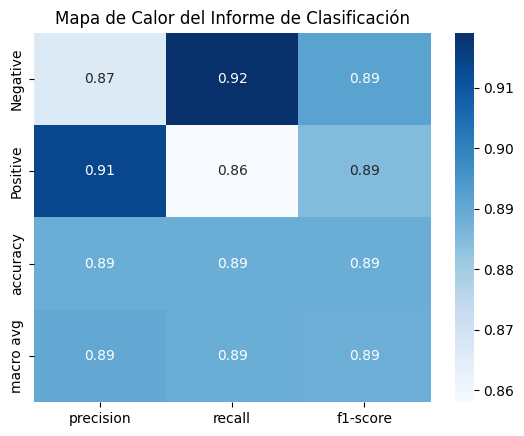

In [47]:
report = classification_report(targets, predicted_classes, target_names=["Negative", "Positive"], output_dict=True)
df = pd.DataFrame(report).transpose()
sns.heatmap(df.iloc[:-1, :].drop(columns="support"), annot=True, cmap="Blues", fmt=".2f")
plt.title("Mapa de Calor del Informe de Clasificación")
plt.show()

**Explicación del Código**

````
Se calcula y muestra la matriz de confusión, que es una representación visual de las predicciones del modelo en comparación con las etiquetas reales.
Utiliza las funciones confusion_matrix() y plot_confusion_matrix() para generar y mostrar la matriz respectivamente.
La matriz se normaliza para resaltar las proporciones y mejorar la interpretación.
````

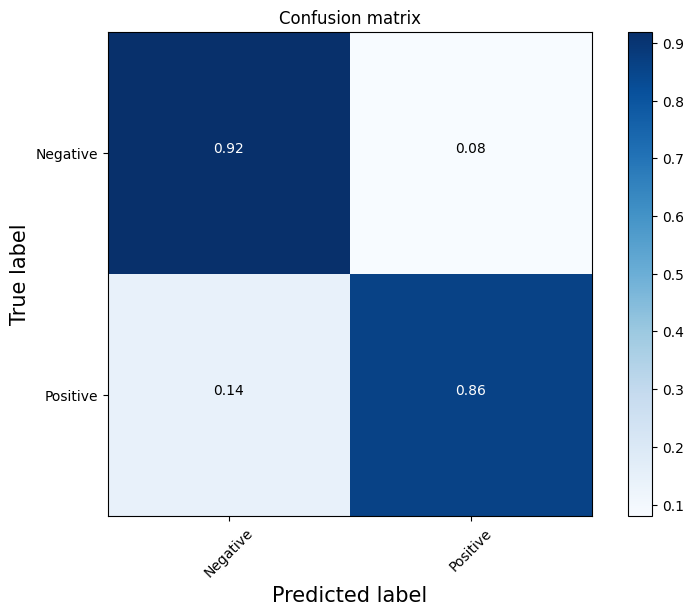

In [41]:
# print the confusion matrix
cnf_matrix = confusion_matrix(targets, predicted_classes, labels=[0, 1])
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,classes=['Negative','Positive'],
    normalize=True,
    title='Confusion matrix'
)

**Explicación del Código**

````
En final, se realiza una evaluación visual mostrando una muestra de las primeras 20 revisiones limpiadas junto con sus etiquetas reales y las salidas del modelo.
Utiliza un bucle for para iterar sobre las revisiones, las etiquetas reales (targets) y las salidas del modelo (outputs).
Para cada iteración, imprime el texto de la revisión, su etiqueta real y la salida predicha por el modelo.
Esto proporciona una forma rápida de inspeccionar visualmente cómo el modelo está clasificando las revisiones en comparación con las etiquetas reales.
````

In [49]:
#visual evalution
for review, target, output in zip(cleaned_data.review.values[:20], targets, predicted_classes):
  print(f"Text: {review}")
  print(f"Target: {target}\tOutput: {output}\n")

Text: one of the other reviewers has mentioned that after watching just oz episode you ll be hooked. they are right, as this is exactly what happened with me. br br the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word. br br it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. br br i would say the main appeal of the show is due to the fact that it g

# 8. Preguntas

8.1. La función **text_cleaning** se utiliza para limpiar el texto de caracteres, puntuación, etc. que añaden ruido a los datos y dificultan el aprendizaje. ¿Cuál crees que ha sido el proceso para identificar los requerimientos de limpieza de los datos y que se ven reflejados es esta función?
¿Crees que se podría mejorar esta función?

**< Respuesta >**

````
....
````

8.2. En la plantilla, ¿Cuál es el propósito de la siguiente línea de código?

**model.to(DEVICE)**

**< Respuesta >**

````
...
````